# Image and equation solving 

EDA notebook to inspect the images to be fed to the model.
And to find out how I can make openCV's findcontours combine contours of individual traces that should be read as a single symbol

Notebook by Martijn de Vries <br>
martijndevries91@gmail.com

In [42]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches

#tensorflow
from tensorflow.keras.preprocessing.image import img_to_array, load_img

First of all, how images of individual symbols do we have?

In [15]:
label_dirs = glob.glob('../processed_images/*')

What symbols are on the images, and how many in each class?

In [20]:
label_dic = {}
for label_dir in label_dirs:
    label = label_dir.split('label_')[-1]
    label_imgs = glob.glob(label_dir + '/*png')
    label_dic[label] = len(label_imgs)

In [21]:
len(label_dic)

100

What is their distribution?

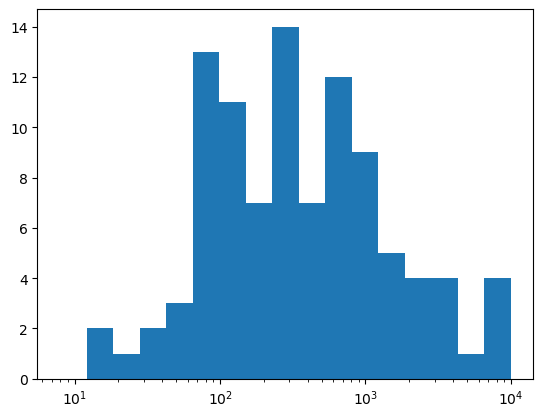

In [39]:
logbins = np.logspace(0.9, 4, 18)

plt.hist(label_dic.values(), bins=logbins)
plt.xscale('log')
plt.show()

And the cumulative distribution

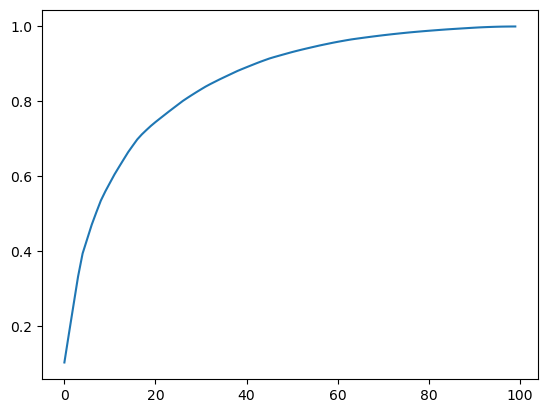

In [206]:
s_v = sorted(label_dic.values())[::-1]
s_cumu = np.cumsum(s_v)/sum(label_dic.values())

plt.plot(s_cumu)
plt.show()

## Equation solving EDA

I want to see how well openCV findcontours can actually read single symbols. One of the most obvious issues would be the 'equals', and 'greater or equal /lesser or equal than' signs. Those will always be read as two individual contours, given that they are separated from each other by some distance

In [219]:
eq_labels = ['=',  '\leq', '\geq']
eq_imgs = []
for label in eq_labels:
    eq_imgs += glob.glob('../processed_images/label_' + label + '/*')

Plot how much these boxes typically overlap for equal signs

In [220]:
def calc_box_overlap(img_file):
    img = cv2.imread(img_file,cv2.IMREAD_GRAYSCALE)

    ret,thresh=cv2.threshold(img,230,255,cv2.THRESH_BINARY)
    ctrs, ret =cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cnt=sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])

    r_l = [[],[]]
    for i,c in enumerate(cnt[1:3]):
        x1,y1,x2,y2= cv2.boundingRect(c)
        r_l[1].append(x2+x1)
        r_l[0].append(x1)
    
    
    totl = max(r_l[1]) - min(r_l[0]) 
    overlap = min(r_l[1]) - max(r_l[0])
    try:
        return overlap/totl
    except:
        return 0

In [221]:
ol = []
for img_file in eq_imgs:
    ol.append(calc_box_overlap(img_file))

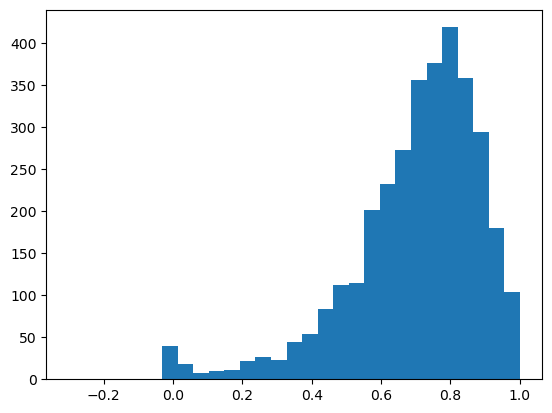

In [222]:
linbins = np.linspace(-0.3, 1, 30)
plt.hist(ol, bins=linbins);

In [223]:
ol_arr = np.array(ol)
bo = np.where(ol_arr < 0.25)[0]
print(f'Fraction of equal signs with less than 25% overlap: {len(bo)/len(ol)}')

Fraction of equal signs with less than 25% overlap: 0.03419565863812073


Based on this, I  might be able to make some inferences about when two boxes are likely to belong together or not

197 72 178 262
225 232 233 182


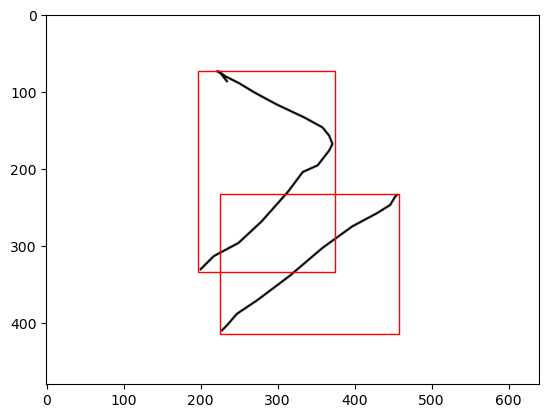

In [359]:
img = cv2.imread(eq_imgs[-1],cv2.IMREAD_GRAYSCALE)

ret,thresh=cv2.threshold(img, 230,255,cv2.THRESH_BINARY)
ctrs, ret =cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cnt=sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])

fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')

r_l = [[],[]]
for i,c in enumerate(cnt[1:]):
    x1,y1,x2,y2= cv2.boundingRect(c)
    print(x1,y1, x2, y2)

    rect = patches.Rectangle((x1, y1), x2, y2, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    

How well can findContours do in general?

In [225]:
full_eq_imgs = glob.glob('../full_eq_imgs/*png')

In [1159]:
def resolve_symbols_on_img(img_file):
    img = cv2.imread(img_file,cv2.IMREAD_GRAYSCALE)
    ret,thresh=cv2.threshold(img,230,255,cv2.THRESH_BINARY)
    ctrs, ret =cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cnt=sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
    
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')

    for i,c in enumerate(cnt[1:]):
        x1,y1,x2,y2= cv2.boundingRect(c)
        rect = patches.Rectangle((x1, y1), x2, y2, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    return

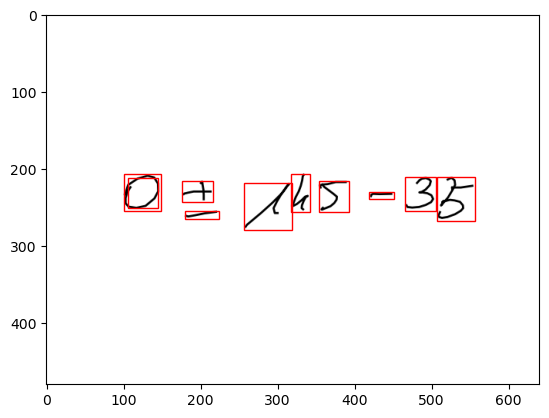

In [1162]:
resolve_symbols_on_img(full_eq_imgs[23])

There are some issues with this that I'll need to figure out
1) if one box is  completely inside another box, I want to get rid of it. However if there are many boxes inside a box (like under a root) then they should remain
2) if two boxes are close to each other and are likely to form an equals or plusminus or leq/geq sign, turn them into one box

In [1382]:
def box_inside_box(coords1, coords2):
    """
    returns True if the second box is inside the first box
    coords are in the form [x1, y1, x2, y2]
    """
    
    if (coords2[1] >= coords1[1]) and (coords2[3] <= coords1[3]) and (coords2[0] >= coords1[0]) and (coords2[2] <= coords1[2]):
        return True
    else:
        return False
    
def remove_box_inside_box(box_list):
    """
    Given a list of boxes with coordinates [x1 y1 x2 y2]
    Check if any boxes are completely inside another box. 
    If there are fewer than 3 boxes inside another box (eg. its not a root with lots of stuff in it)
    Assume these are wrong and remove them
    """
    pop_boxes = []
    for i, box in enumerate(box_list):
        #the list of all the other boxes to check against
        ebox_list = [ebox for ebox in box_list if box != ebox]
        isInside = False
        eq_i = 0 #counter to keep track of how many boxes are inside other boxes
        
        boxes_to_pop = []
        for j,ebox in enumerate(ebox_list):
            #check how many boxes are inside this box
            if box_inside_box(box, ebox) == True:
                isInside = True
                eq_i += 1
                boxes_to_pop.append(ebox)
        
        #add all the boxes to the to pop list
        if (isInside == True) and (eq_i <= 3):
            pop_boxes.extend(boxes_to_pop)

    for pop_box in pop_boxes:
        try:
            box_list.remove(pop_box)
        except:
            pass
    return box_list

In [ ]:
def has_overlap(coords1, coords2):
    """
    check if first box overlaps at least 25% with the second box in x-coordinates
    """
    r_l = [[],[]]
    for i in range(2):
        r_l[i].extend([coords1[i*2], coords2[i*2]])
    
    #the total x-space extended by the two boxes
    totl = max(r_l[1]) - min(r_l[0]) 
    overlap = min(r_l[1]) - max(r_l[0])
    
    xlen_b1 = coords1[2] - coords1[0]
    xlen_b2 = coords2[2] - coords2[0]
    lenlist = [xlen_b1, xlen_b2]
    
    #if one box extends beyond the other on both sides, the overlap should just be 1
    if max([xlen_b1, xlen_b2]) == totl:
        overlap = totl

    if overlap/totl > 0.25:
        return True
    else:
        return False

def merge_boxes(coords1, coords2):
    """
    Take two boxes with coords [x1, y1, x2, y2]
    and merge them into a box spanning both
    """
    new_x1 = min(coords1[0], coords2[0])
    new_y1 = min(coords1[1], coords2[1])
    new_x2 = max(coords1[2], coords2[2])
    new_y2 = max(coords1[3], coords2[3])
    
    return new_x1, new_y1, new_x2, new_y2

In [1475]:
def infer_boxes_to_merge(boxl):
    """
    For a list of boxes that are overlapping in x-coordinates, check which box is the closest in distance either above or below the box
    If a box on either side matches certain criteria about the x and ylengths, assume it's two components of an equals sign or ! or i, etc.
    And return the coordinates of the two boxes that should be merged
    """
    
    box_0 = boxl[0]
    y_c0 = (box_0[3] + box_0[1])/2
    
    #find two closest vertical boxes on either side (above, and below)
    ydist_min, ydist_max = 1000, 1000
    box_i_min, box_i_max = 0, 0
    for i,box in enumerate(boxl[1:]):
        yb = (box[3] + box[1])/2
        
        ydist = yb - y_c0
        if ydist < 0:
            if abs(ydist) < ydist_min:
                ydist_min = abs(ydist)
                box_i_min = i+1
        elif ydist >= 0:
            if ydist < ydist_max:
                ydist_max = ydist
                box_i_max = i+1

    #these are the two closest boxes above and below the box
    cbox_down = boxl[box_i_min]
    cbox_up = boxl[box_i_max]
    
    #get lengths in x-coordinates for the box and the two closest boxes
    xlen_box = box_0[2] - box_0[0]
    xlen_cbox_up = cbox_up[2] - cbox_up[0]
    xlen_cbox_down = cbox_down[2] - cbox_down[0]
    
    xlens_up = [xlen_box, xlen_cbox_up]
    xlens_down = [xlen_box, xlen_cbox_down]
    
    #also check if the one of the boxes it not much longer vertically than the other one
    ylen_box = box_0[3] - box_0[1]
    ylen_cbox_up = cbox_up[3] - cbox_up[1]
    ylen_cbox_down = cbox_down[3] - cbox_down[1]
    
    ylens_up = [ylen_box, ylen_cbox_up]
    ylens_down = [ylen_box, ylen_cbox_down]
    
    #if 1) one of the boxes is not more than 1.8 as long (in x-coords) as the other one
    # AND 2) the y-length of one box is not more than 4x that of the other one AND 5x the ylength of the smallest box is larger than the y-distance between the boxes
    # AND 3) the closest box is not the box itself
    # then assume that the boxes should be merged
    
    is_ol_up = max(xlens_up) < 1.7*min(xlens_up) and   \
            (max(ylens_up) < 4*min(ylens_up) and 5*min(ylens_up) > ydist_max) \
            and cbox_up != box_0
    
    is_ol_down = max(xlens_down) < 1.7*min(xlens_down) and \
            (max(ylens_down) < 4*min(ylens_down) and 5*min(ylens_down) > ydist_min ) \
            and cbox_down != box_0
    

    if is_ol_up == True:
        return [box_0, cbox_up]
    elif is_ol_down == True:
        return [box_0, cbox_down]
    else:
        return [box_0]

In [1476]:
def resolve_symbols_on_img_3(img_file):
    
    #find contours
    img = cv2.imread(img_file,cv2.IMREAD_GRAYSCALE)
    ret,thresh=cv2.threshold(img,230,255,cv2.THRESH_BINARY)
    ctrs, ret =cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cnt=sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0] + cv2.boundingRect(ctr)[1])
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')

    box_list = []
    
    #get the bounding boxes for all contours
    for i,c in enumerate(cnt[1:]):
        x1,y1,x2,y2= cv2.boundingRect(c)
        x2 += x1
        y2 += y1
        
        box_list.append([x1, y1, x2, y2])
    
    #remove boxes that are inside another box under certain criteria
    box_list = remove_box_inside_box(box_list)
    
    #now check if any boxes overlap with each other in x coordinates
    tot_overlap_boxes = []
    merged_box_list = []

    for i, box in enumerate(box_list):
        #the list of all the other boxes to check against
        ebox_list = [ebox for ebox in box_list if box != ebox] 
        eq_b = 0
        overlap_boxes = [box]
        for j,ebox in enumerate(ebox_list):
            if has_overlap(box, ebox) == True:
                overlap_boxes.append(ebox)
    
        tot_overlap_boxes.append(overlap_boxes)
        
    pop_boxes = []
    
    #find which of the overlapping boxes might fit the criteria to be merged
    for i in range(len(tot_overlap_boxes)):
        if len(tot_overlap_boxes[i]) > 1:
            boxes_to_merge = infer_boxes_to_merge(tot_overlap_boxes[i])
            if len(boxes_to_merge) == 2:
                #if a pair of boxes to be merged is found, merge them and add the individual boxes to the remove list
                print('merging:', boxes_to_merge)
                merged_box_list.append(merge_boxes(*boxes_to_merge))
                pop_boxes.extend(boxes_to_merge)
    
    #remove all the boxes that were merged
    for pop_box in pop_boxes:
        try:
            box_list.remove(pop_box)
        except:
            pass
    
    tot_boxes = box_list + merged_box_list
    
    #of all the 'correct' boxes that are left, I want to infer their 'level'
    box_levels = infer_box_levels(tot_boxes)
    
    colors = ['r', 'g', 'b', 'g']
    for i, box in enumerate(tot_boxes):
        x1 = box[0]
        y1 = box[1]
        x2 = box[2] - box[0]
        y2 = box[3] - box[1]
   
        rect = patches.Rectangle((x1, y1), x2, y2, linewidth=1, edgecolor='r', facecolor='none')

        ax.add_patch(rect)
        ax.text(x1, y1, str(box_levels[i]))
    return box_levels


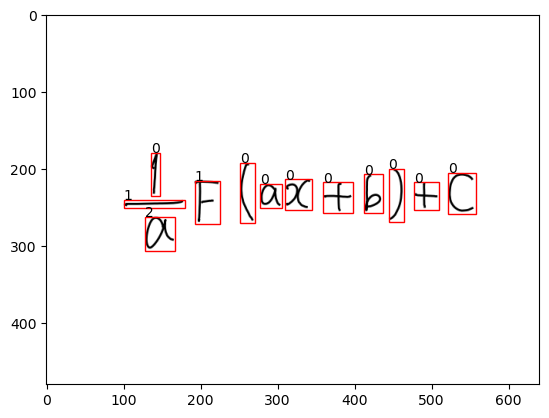

In [1484]:
level_boxes = resolve_symbols_on_img_3(full_eq_imgs[65])

# level_boxes

Next: I'll need some way to infer the order of symbols in the equation:

In [1317]:
def infer_box_levels(box_list):
    """
    Given a list of boxes with coordinates [x1 y1 x2 y2],
    Find out which 'level' of the equation the box is in
    """
    
    xmins, ymins, xmaxs, ymaxs = [np.array([box_list[j][i] for j in range(len(box_list))]) for i in range(4)]

    #lets call the lowest y coordinate and lowest x coordinate of the grid 0 
    xmins -=  np.min(xmins)
    xmaxs -= np.min(xmins)
    ymins -= np.min(ymins)
    ymaxs -= np.min(ymins)
    
    xcs = (xmins + xmaxs) * 0.5
    ycs = (ymins + ymaxs) * 0.5
 
    #figure out levels
    box_level_list = [[box_list[0]]]
    box_level_labels = [0]
    
    #loop over each box
    for b, box in enumerate(box_list[1:]):
        xc =  (box[0] + box[2])/2
        yc = (box[3] + box[1])/2
        add_new_level = True
        #loop over the level list. if the box fits within one of the already existing levels, add it there
        for l, level_boxes in enumerate(box_level_list):
            #find the minn and max xs for all the boxes in this level
            xmins_l, ymins_l, xmaxs_l, ymaxs_l = [np.array([level_boxes[j][i] for j in range(len(level_boxes))]) for i in range(4)]
            
            xmin_l = np.min(xmins_l)
            xmax_l = np.max(xmaxs_l)
            ymin_l = np.min(ymins_l)
            ymax_l= np.max(ymaxs_l)
            
            if ymin_l < yc < ymax_l:
                box_level_list[l].append(box)
                box_level_labels.append(l)
                add_new_level = False
                break
        #if no match for the box could be found, add a new level
        if add_new_level == True:
            box_level_list.append([box])
            box_level_labels.append(len(box_level_list)-1)
            
    #Now i'll need to go over all boxes again left-to-right
    #If there are boxes at different levels that overlap in x-coordinates, I should retain the levels of those boxes
    #when I hit a box that has no boxes above or below it, it should be the start of a new level
    
    return box_level_labels